## Body Sections Classifier Framework From Imbalance x-ray Image-Datasets


> ####  SAMUEL ONEKUTU 2114194
> #### CMM 536 ADVANCE DATA SCIENCE
> ##### MSc DATA SCIENCE
> ##### ROBERT GORDON UNIVERSITY,  MARCH 2022


_**keywords**_: classifier, machine learning, x-ray image, imbalance datasets, CNN, class decomposition, 

### INTRODUCTION:

From the past decade; several machine learning algorithms and techniques have been developed for image classification this project aims to create an experimental framework to compare Convolutional Neural Network (CNN) a more classical feature extraction technique using imbalance and balance dataset. i would make use of an _**imbalance datasets**_ to train the models and the reason is because[1] in the real world problems often involves accessing data generate are in different proportion and a model developed without accounting for this would be biased .

#### Data mining sources:

> * 500 X-ray images of hands gotten from [Stanford University School of Medicine MURA Dataset](https://stanfordmlgroup.github.io/competitions/mura/) hand images were selected from the set containing hands and wrist 
> *  702 X-ray images Knee from [Stanford University School of Medicine MURA Dataset](https://stanfordmlgroup.github.io/competitions/mura/) data contains both positive and negative classes of knee X-rays 
> * and 1000 Chest X-ray from [data.mendeley.com/dataset](https://data.mendeley.com/datasets/t9ndx37v5h/1) data contains both positive and negative classes of X-rays


###### some primary libraries

In [248]:
import numpy as np
import pandas as pd
import matplotlib 
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import time

## Part 1: Import 3 image datasets

In [181]:
# this data is stored in a local directory "IMAGE/CHEST"
# using os to locate files and cv2 to read into Numpy arrays
resize_width = 128
resize_height = 128
path = "IMAGES"
IMAGES = [] # List to append the images as 2D numpy arrays.
TARGET = [] # List to append the target all ch
ORIGINALREPO = [] # Create a repo for flattened pixels


for root, dirs, files in os.walk(path):
     for file in files:
        with open(os.path.join(root, file), "r") as auto:
            try:
                img = cv2.imread(root+'/'+file, 0)   # cv2 reads image to a 2d ie grayscale
                img = cv2.resize(img, (resize_width, resize_height)) # image resize to 128/128
                IMAGES.append(img)
                # Append the flattened image to the pixel repo
                ORIGINALREPO.append(img.flatten()) #note image can be reshape back to 128,128
                # Append the folder where the image is to the target list
                TARGET.append(root.replace(path,'').replace('\\','').replace('/',''))
            except Exception as e:
                print("Invalid file "+file+" skipped.")
# Convert the repo list into numpy array
ORIGINALREPO = np.array(ORIGINALREPO) 

for part in np.unique(TARGET):
    print ('{} has {} images'.format(part,TARGET.count(part)))
print("TOTAL IMAGES =",len(TARGET))

CHEST has 1000 images
HANDS has 500 images
KNEE has 702 images
TOTAL IMAGES = 2202


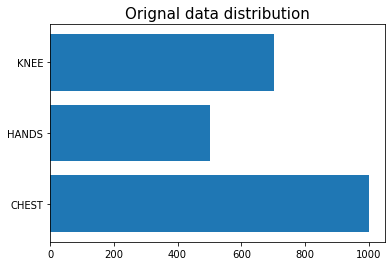

In [182]:
parts = np.unique(TARGET)
count=[]
for part in parts:
    count.append(TARGET.count(part))
plt.barh(parts,count)
plt.title("Orignal data distribution",size = 15)
plt.show()
# distribution = pd.DataFrame(count,parts)
# distribution.plot(kind= "bar")

Text(0.5, 1.0, 'display of sample un-processed images')

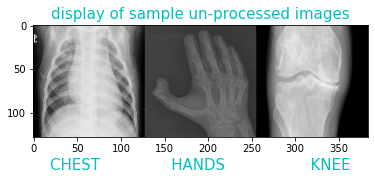

In [183]:
im_sample=np.concatenate((IMAGES[0],IMAGES[1000],IMAGES[1553]),axis=1)
plt.imshow(im_sample,cmap='Greys_r')
plt.xlabel("CHEST               HANDS                  KNEE",color='c',size=15)
plt.title("display of sample un-processed images",size=15,color="c")

#### preprocessing
The only preprocessing applied is resizing the images to 128/128 pixels so we don't lose too much information i would normalize the pixels later for a CNN learning task [2]. while the original data list "ORIGINALREPO","IMAGES" and "TARGET" will remain unchanged, newer copies of modified images will be generated to suit the Algorithms when necessary.

# Part 2 Validations: experiments

#### AIM: 
To compare the performace of a Convolutional Neural Network-CNN with:
1. Original imbalance data set
2. Image-augmented balanced set
3. Feature extracted imbalanced set
4. Lastly with feature class decomposition techique to address imbalance.

#### *methodology*
 * split data to traing and testing
 * design my Convolutional Neural Network-CNN; with KERAS backend.
 * train on a  Convolutional Neural Network-CNN with original imbalance datasets, test and record performance  after only **1 epochs** (so I can observe performance difference because I assume if given enough epochs cycles all 4 CNN models will all be optimal and no difference maybe seen)
 * repeat experiment with augmented image oversampling (balanced) datasets
 * use feature extraction technique (HOG) on the original dataset and train with the CNN
 * balance the classes using class decomposition on the training set and repeat the experiment
 * compare findings


#### splitting the data

In [225]:
# RENAMING TARGET LABELS THAT IS: 0 FOR 'CHEST', 1 FOR 'HANDS' AND 2 FOR 'KNEE' so TARGET CAN WORK WITH A CLASSIFIER ALOGRITHM
def re_label(targets):
    TAR=[]
    for part in targets:
        if part == 'CHEST':
            TAR.append(0)
        elif part == 'HANDS':
            TAR.append(1)
        else:
            TAR.append(2)
    return (TAR)

In [226]:
# splitting ORIGINALREPO AND IMAGES TO TRAIN_TEST SET making sure to use stratify to split along the different body parts
from sklearn.model_selection import train_test_split
# also setting  seed (for reproducibility)
np.random.seed(101)

ORIGINALREPO_train,ORIGINALREPO_test,OriginalTARGET_train,OrignalTARGET_test=train_test_split(ORIGINALREPO,TARGET,stratify=TAR,test_size=0.3)
IMAGES_train,IMAGES_test,OTARGET_train,OTARGET_test=train_test_split(IMAGES,TARGET,stratify=TARGET,test_size=0.3)
TARGET_train = re_label(OTARGET_train)
TARGET_test = re_label(OTARGET_test)

## Experiment 1
### training on a Convolutional Neural Network-CNN; KERAS with imbalance datasets


In [227]:
# reshaping data for Neural Network
X_train_reshape = np.array(IMAGES_train,dtype='float64').reshape(len(IMAGES_train), 128, 128, 1)
X_test_reshape = np.array(IMAGES_test,dtype='float64').reshape(len(IMAGES_test), 128, 128, 1)

# changing labels to array like categorical labels vital for CNN training
Y_train_categorical = np_utils.to_categorical(TARGET_train, 3)
cat_TARGET_test = np_utils.to_categorical(TARGET_test, 3)  # creating categorical output for test data

# normalising
X_train_reshape /= 255 
X_test_reshape /= 255

print('Original Targets',OTARGET_train[0:4],"\n Relabeled Targets as",TARGET_train[0:4], '\n categorical split for CNN \n',Y_train_categorical[0:4]) # sample of output

Original Targets ['HANDS', 'HANDS', 'CHEST', 'KNEE'] 
 Relabeled Targets as [1, 1, 0, 2] 
 categorical split for CNN 
 [[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [334]:
# Define model architecture
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D,ZeroPadding2D,Input

model1 = Sequential()

model1.add(Input((128,128,1)))   # dimesion of orignal image uploaded
model1.add(ZeroPadding2D((2, 2))) # pads the border of input image with zeroes
model1.add(Conv2D(32, (5, 5), activation='relu'))  # # because image size is large I used 5,5 filter size
model1.add(MaxPooling2D(pool_size=(2,2)))  # dropping samples to reduce overfitting
model1.add(Dropout(0.25))# to reduce overfitting
model1.add(Flatten())  # flatten to come before dense output layer
model1.add(Dense(81, activation='relu'))   # the pre output dense layer greatly increases accuarcy density= square(no.categories)
model1.add(Dropout(0.25))# to reduce overfitting some more
model1.add(Dense(3, activation='softmax'))  # output layer to have 3 for the 3 categories
# used only 1 Conv2D layer for 98% accuracy


In [335]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

my main CNN architecture
1. Input Layer with dimesion(128,128) of orignal image uploaded
2. Pads the border of input image with zeroes for the fil
3. Conv inner layer with 5,5 filter size because of the image dimesion
4. dropping features to reduce overfitting with Maxpooling
5. 2 dropout layer to reduce overfitting too
6. 1st dense layer with large enough size for feature
7. another dropout layer to reduce overfitting too
8. 2nd dense layer size of categories of possible prediction

lastly opitmized with Adam optimizer with loss for multi class category and to output accuracy of prediction 

summary below and total number of features generated

In [336]:
model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_14 (ZeroPadd  (None, 132, 132, 1)      0         
 ing2D)                                                          
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      832       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 flatten_14 (Flatten)        (None, 131072)            0         
                                                                 
 dense_28 (Dense)            (None, 81)              

In [337]:
np.array(Y_train_categorical).shape

(1541, 3)

In [338]:
t = time.perf_counter()

model1.fit(X_train_reshape,np.array(Y_train_categorical),batch_size=20, epochs=1,verbose=1) # small batch better speed

t1 = time.perf_counter() - t

78/78 [==============================] - 22s 266ms/step - loss: 0.7641 - accuracy: 0.7878


In [341]:
#help(Dense)
print ("elsapsed time for model on my PC was ",round(t1),'s')

elsapsed time for model on my PC was  22 s


In [342]:
# the prediction are stored as floats in array. code below extract it to integers in a list
pred = model1.predict(X_test_reshape)
pred_test=[]
for x in pred:
    pred_test.append([round(i) for i in list(x)])
pred_test = np.array(pred_test,dtype='float32')
pred_test[0:2] # sample of output


array([[0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

#### displaying reports for F1 , Recall and Precision

In [343]:
from sklearn.metrics import classification_report
print(classification_report(cat_TARGET_test, pred_test, target_names=['CHEST','HANDS','KNEE']))

              precision    recall  f1-score   support

       CHEST       1.00      0.96      0.98       300
       HANDS       1.00      0.95      0.98       150
        KNEE       0.94      1.00      0.97       211

   micro avg       0.98      0.97      0.98       661
   macro avg       0.98      0.97      0.98       661
weighted avg       0.98      0.97      0.98       661
 samples avg       0.97      0.97      0.97       661



C:\Users\program_AD\anaconda3\envs\pro_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [351]:
# saving f1 sorce a dataframe
x=  classification_report(cat_TARGET_test, pred_test, target_names=['CHEST','HANDS','KNEE'])
model1f1 = [ r.split(" "*6)[4] for r in x.split("\n\n")[1].split("\n") ]
f1scores = pd.DataFrame(columns=['CHEST','HANDS','KNEE'])
f1scores.loc["experiment1"]= model1f1

## experiment 2

### BALANCING DATA SET using oversampling 
* in balancing the data set it would be better to balance training set before training discribed by  [Emily Potyraj](https://towardsdatascience.com/4-ways-to-improve-class-imbalance-for-image-data-9adec8f390f1)
* the oversampling technique involves random sampling of existing images, then augmenting them randomly.
* keep this in mind I would apply oversampling to only the training set as instructed to keep the testing data as completely unseen to the model during training.
* so I would split the test data away before balancing the training set

#### Oversampling with sklearn.utils  
* The RESAMPLE tool in sklearn.utils randomly resamples the smaller category(hand and knee) to the specified sample size number n of choice (number of chest images)
* After balancing the data i will apply randomly my designed **list of augmentation** functions(cv2 image function)



#### 1st Creating List of Augmentation Function

In [305]:
# DEFINING IMAGE AUGMENTATION FUNCTION
# Normal
def normal (img):
    return(img)

# rotate
def rotate (img):
    return (img.transpose((1,0)))

# rotate 180
def rotate180(img):
    img = np.rot90(img)
    return(np.rot90(img))

# image zoom +1
resize_width = 128
resize_height = 128
def zoom1 (img):
    img = img[4:(resize_height-4), 4:(resize_width-4)]
    return (cv2.resize(img, (resize_width, resize_height)))

# image zoom +2
resize_width = 128
resize_height = 128
def zoom2 (img):
    img = img[16:(resize_height-16), 16:(resize_width-16)]
    return (cv2.resize(img, (resize_width, resize_height)))

#tilt from opencv tutorials
def tilt (img):
    pts1 = np.float32([[16,16],[100,16],[16,100]])
    pts2 = np.float32([[2,64],[64,16],[64,128]])
    M = cv2.getAffineTransform(pts1,pts2)
    dst = cv2.warpAffine(img,M,(128,128))
    return(dst)

# dialate
def dialate (img):
    return(cv2.dilate(img,cv2.getStructuringElement(cv2.MORPH_RECT,(6,6))))

# erode
def erode (img):
    return(cv2.erode(img,cv2.getStructuringElement(cv2.MORPH_RECT,(6,6))))

# padding right and up
def shiftright (img):
    resize_width = 128
    resize_height = 128
    h = np.full((128,16),img[1,1])
    w = np.full((16,128+16),img[1,1])
    img = np.concatenate((h,img),axis=1)
    img = np.concatenate((w,img),axis=0)
    return (cv2.resize(img, (resize_width, resize_height)))

# padding left and down
def shiftleft (img):
    resize_width = 128
    resize_height = 128
    h = np.full((128,16),img[126,126])
    w = np.full((16,128+16),img[126,126])
    img = np.concatenate((img,h),axis=1)
    img = np.concatenate((img,w),axis=0)
    return (cv2.resize(img, (resize_width, resize_height)))

# brighter
def brighter (img):
    img2 = np.where((img<img.max()*0.5),img,img+(img.max()*0.5))
    return (img2/img2.max())

In [306]:
functionslist = [normal,rotate,rotate180,zoom1,zoom2,tilt,shiftright,shiftleft,brighter]
# note that normal will repeated 50% of the time to reduce effect of the augmentation on the final experiment

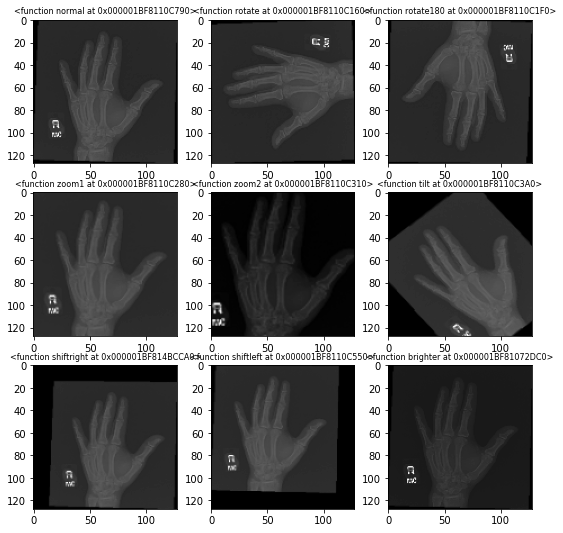

In [307]:
# sample of image augmentation function
fig,axes = plt.subplots(3,3, figsize=[9,9])
for i,dat in enumerate(axes.flatten()):
    aug_img = list(map(functionslist[i],[IMAGES_train[12]]))
    dat.imshow(aug_img[0],cmap="Greys_r")
    dat.set_title(functionslist[i],size=8)
plt.show()
 

### steps for balancing
* split test out
* display class distribution
* then identify classes to balanced
* separate them classes 
* balance implementing (oversample and augmentation)
* merge together and shuffle again
* lastly confirm

In [300]:
# SPLIT DATA TO SEPERATE TRAIN AND TEST
IMAGES_train2,IMAGES_test2,TARGET_train2,TARGET_test2=train_test_split(IMAGES,TARGET,stratify=TARGET,test_size=0.3)

<ipython-input-301-f99c543d701b>:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.barh(parts,count,color="rgb")


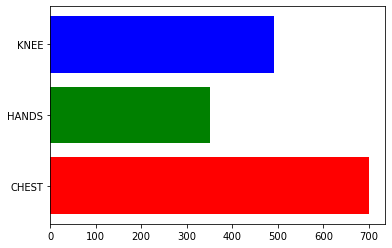

CHEST has 700 images
HANDS has 350 images
KNEE has 491 images
TOTAL TRAINING IMAGES = 1541


In [301]:
# DISPLAYING DISTRIBUTION
parts = np.unique(TARGET_train2)
count=[]
for part in parts:
    count.append(TARGET_train2.count(part))
plt.barh(parts,count,color="rgb")
plt.show()

for part in np.unique(TARGET_train2):
    print ('{} has {} images'.format(part,TARGET_train2.count(part)))
print("TOTAL TRAINING IMAGES =",len(TARGET_train2))
# distribution = pd.DataFrame(count,parts)
# distribution.plot(kind= "bar")

 **700 is the highest class so I would balance images for hand and knee to 700**

In [308]:
# SEPARATING IMAGES
chest = []
hands = []
knee = []
for i in range (len(TARGET_train2)):
    if TARGET_train2[i] == 'CHEST':
        chest.append(IMAGES_train2[i])
    elif TARGET_train2[i] == 'HANDS':
        hands.append(IMAGES_train2[i])
    elif TARGET_train2[i] == 'KNEE':
        knee.append(IMAGES_train2[i])

len(hands)

350

In [309]:
# OVER SAMPLING CLASS HANDS AND KNEE to 700 images
from sklearn.utils import resample
Re_hands=resample(hands, replace=True, n_samples=700, random_state=101, stratify=None)
Re_knee=resample(knee, replace=True, n_samples=700, random_state=101, stratify=None)
print("new length of hands {} and new length of Knee {}".format(len(Re_hands),len(Re_knee)))
# note resample function only made new random duplicates

new length of hands 700 and new length of Knee 700


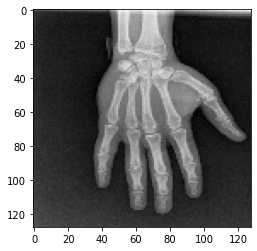

In [327]:
# APPLY AUGMENTATION TO THIS TWO CLASS
functionslist = [rotate,rotate180,zoom1,zoom2,tilt,shiftright,shiftleft,brighter]

# first define a function to apply agumentation functions randomly
import random
def random_agument (imgarray,start_index):
    newimagelist = [] 
    for i in range (len(imgarray)):
        if i < start_index:
            img = [imgarray[i]]
            newimagelist.append(img[0])
        else:
            img = [imgarray[i]]   # square brackets so it is iterable
            augimg = list(map(functionslist[random.randint(0,7)],img))[0]   # note function list defined globally
            newimagelist.append(augimg)
    return (newimagelist)

Aug_hands = random_agument(Re_hands,len(hands))  # Augment functions start from 387th image to 700th
Aug_Knee = random_agument(Re_knee,len(knee))  # Augment functions start from 491st image to 700th
plt.imshow(Aug_hands[689],cmap= 'Greys_r')
plt.show()

<ipython-input-328-43edc4ab12bf>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.barh(Newdata_namelist,Newdata_count,color="rgb")


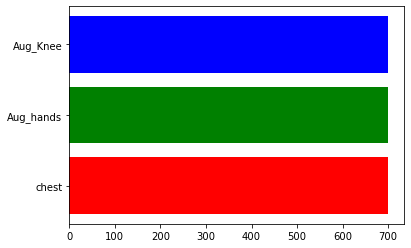

In [328]:
# CONFIRMING IMAGE SAMPLE DISTRIBUTION
newdatalist = [chest,Aug_hands,Aug_Knee]
Newdata_namelist = ['chest','Aug_hands','Aug_Knee']
Newdata_count=[len(part)for part in newdatalist]
plt.barh(Newdata_namelist,Newdata_count,color="rgb")
plt.show()


In [329]:
## Merging three data set together creating target list
AUG_train2=np.concatenate((chest,Aug_hands,Aug_Knee))
AUG_TAR = np.concatenate((np.full([len(chest),],0),np.full([len(Aug_hands),],1),np.full([len(Aug_Knee),],2)))
print("total length of images and labels are {} and {} respectively".format(len(AUG_train2),len(AUG_TAR)))
# note that chest==0, hands==1 and knee==2

total length of images and labels are 2100 and 2100 respectively


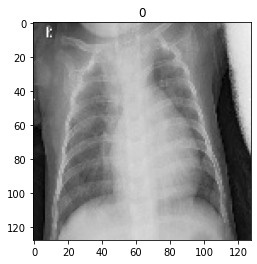

In [330]:
# testing Labels and image pairing
np.unique(AUG_TAR)
i=699
plt.title(AUG_TAR[i])
plt.imshow(AUG_train2[i],cmap='Greys_r')

### training on a 2nd Convolutional Neural Network-CNN2 with balanced datasets

In [345]:
# reshaping data for Neural Network
X_train_reshape2 = np.array(AUG_train2,dtype='float64').reshape(len(AUG_train2), 128, 128, 1)
X_test_reshape2 = np.array(IMAGES_test2,dtype='float64').reshape(len(IMAGES_test2), 128, 128, 1)

# changing labels to array like categorical labels vital for CNN training
Y_train_categorical2 = np_utils.to_categorical(AUG_TAR, 3)
cat_TARGET_test2 = np_utils.to_categorical(re_label(TARGET_test2), 3) # function 're_label' defined earlier to change 'CHEST'==0, 'HANDS'==1 and 'KNEE'==2 

# normalising
X_train_reshape2 /= 255 
X_test_reshape2 /= 255

In [346]:
# Define model architecture same as with model1 above

model2 = Sequential()

model2.add(Input((128,128,1))) 
model2.add(Conv2D(32, (5, 5), activation='relu'))
model2.add(ZeroPadding2D((2, 2))) # pads the border of input image with zeroes
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))# to reduce overfitting
model2.add(Flatten())  # flatten to come before dense output layer
model2.add(Dense(81, activation='relu'))   # the pre output dense layer greatly increases accuarcy density= square(no.categories)
model2.add(Dropout(0.25))# to reduce overfitting
model2.add(Dense(3, activation='softmax'))  # output layer to have 3 for the 3 categories

model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 

# model2.summary()

In [347]:
# training model2 on balanced dataset
model2.fit(X_train_reshape2,np.array(Y_train_categorical2),batch_size=20, epochs=1,verbose=1) # small batch better speed

105/105 [==============================] - 31s 292ms/step - loss: 0.3518 - accuracy: 0.8752


In [348]:
# the prediction are stored as floats in array. code below round up it to integers in a list
pred = model2.predict(X_test_reshape2)
pred_test=[]
for x in pred:
    pred_test.append([round(i) for i in list(x)])
pred_test2 = np.array(pred_test,dtype='float32')

In [350]:
from sklearn.metrics import classification_report
print(classification_report(cat_TARGET_test2, pred_test2, target_names=['CHEST','HANDS','KNEE']))

              precision    recall  f1-score   support

       CHEST       1.00      0.98      0.99       300
       HANDS       0.99      0.97      0.98       150
        KNEE       0.96      1.00      0.98       211

   micro avg       0.98      0.98      0.98       661
   macro avg       0.98      0.98      0.98       661
weighted avg       0.99      0.98      0.98       661
 samples avg       0.98      0.98      0.98       661



* the results are outstanding, balanced data set outperformed unbalance data in same conditions
* class hand is still not as good as chest and knee

In [352]:
# saving f1 sorce a dataframe
x=  classification_report(cat_TARGET_test2, pred_test2, target_names=['CHEST','HANDS','KNEE'])
model2f1 = [ r.split(" "*6)[4] for r in x.split("\n\n")[1].split("\n") ]
f1scores.loc["experiment2"]= model2f1

## experiment 3
###  Feature extraction (HOG) and the training set and train with the CNN


##### Histogram Oriented Gradiant HOG form skimage.feature

In [353]:
from skimage import feature

In [359]:
# class 
class HOG:  # my hog settings
    def __init__(self, orientations = 9, pixelsPerCell = (8, 8),
        cellsPerBlock = (3, 3), transform = False):
        # store the number of orientations, pixels per cell,
        # cells per block, and whether or not power law
        # compression should be applied
        self.orienations = orientations
        self.pixelsPerCell = pixelsPerCell
        self.cellsPerBlock = cellsPerBlock
        self.transform = transform

    def describe(self, image):
        # compute HOG for the image
        hist = feature.hog(image, orientations = self.orienations,
            pixels_per_cell = self.pixelsPerCell,
            cells_per_block = self.cellsPerBlock,
            transform_sqrt = self.transform)
        ## return the HOG features
        return hist
    
hog = HOG(orientations = 18, pixelsPerCell = (10, 10), cellsPerBlock = (1, 1), transform = True)


In [360]:
# extracting features from orignal data loaded in as 'IMAGES'
# Note target will remain as 'TARGET'
HOG_REPO = [] # Create a list to append the HOG features

for image in IMAGES:
    hogfeatures = hog.describe(image)
    HOG_REPO.append(hogfeatures)

<ipython-input-362-8bb0c7849df0>:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.barh(parts,count,color="rgb")


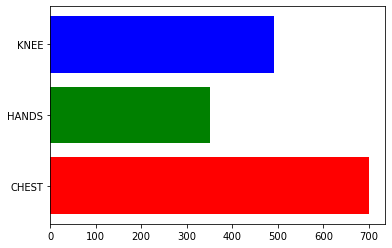

In [362]:
# SPLIT DATA TO SEPERATE TRAIN AND TEST
HOG_train3,HOG_test3,TARGET_train3,TARGET_test3=train_test_split(HOG_REPO,TARGET,stratify=TARGET,test_size=0.3)

# DISPLAYING DISTRIBUTION
parts = np.unique(TARGET_train3)
count=[]
for part in parts:
    count.append(TARGET_train3.count(part))
plt.barh(parts,count,color="rgb")
plt.show()


In [363]:
# reshaping data for Neural Network
X_train_reshape3 = np.array(HOG_train3,dtype='float64').reshape(len(HOG_train3), 2592,1,1) # reshaping list of features to 4D for CNN
X_test_reshape3 = np.array(HOG_test3,dtype='float64').reshape(len(HOG_test3), 2592,1,1)

# changing labels to array like categorical labels vital for CNN training
Y_train_categorical3 = np_utils.to_categorical(re_label(TARGET_train3), 3)
Y_test_categorical3 = np_utils.to_categorical(re_label(TARGET_test3), 3)  
# function 're_label' defined earlier to change 'CHEST'==0, 'HANDS'==1 and 'KNEE'==2 

In [364]:
len(HOG_train3[0])

2592

#### training Extracted imblance FEATURES using CNN as above

In [365]:
# Define model architecture same as with model1 above

model3 = Sequential()

model3.add(Input((2592,1,1))) # expected input shape
model3.add(Conv2D(32, (5,1), activation='relu'))
model3.add(ZeroPadding2D((2, 2))) # pads the border of input image with zeroes
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.25))# to reduce overfitting
model3.add(Flatten())  # flatten to come before dense output layer
model3.add(Dense(81, activation='relu'))   # the pre output dense layer greatly increases accuarcy density= square(no.categories)
model3.add(Dropout(0.25))# to reduce overfitting
model3.add(Dense(3, activation='softmax'))  # output layer to have 3 for the 3 categories

model3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 


In [366]:
# training model3 on imbalanced feature extracted dataset
model3.fit(X_train_reshape3,np.array(Y_train_categorical3),batch_size=20, epochs=1,verbose=1) # small batch better speed

78/78 [==============================] - 12s 151ms/step - loss: 0.2721 - accuracy: 0.8949


In [367]:
# the prediction are stored as floats in array. code below round up it to integers in a list
pred = model3.predict(X_test_reshape3)
pred_test=[]
for x in pred:
    pred_test.append([round(i) for i in list(x)])
pred_test3 = np.array(pred_test,dtype='float32')

In [368]:
print(classification_report(Y_test_categorical3, pred_test3, target_names=['CHEST','HANDS','KNEE']))

              precision    recall  f1-score   support

       CHEST       1.00      0.99      0.99       300
       HANDS       0.99      1.00      1.00       150
        KNEE       0.99      0.99      0.99       211

   micro avg       0.99      0.99      0.99       661
   macro avg       0.99      0.99      0.99       661
weighted avg       0.99      0.99      0.99       661
 samples avg       0.99      0.99      0.99       661



* performance after feature extraction has improve than from the last two experiments

In [369]:
x=  classification_report(Y_test_categorical3, pred_test3, target_names=['CHEST','HANDS','KNEE'])
model3f1 = [ r.split(" "*6)[4] for r in x.split("\n\n")[1].split("\n") ]
f1scores.loc["experiment3"]= model3f1

## experiment 4
###  Balance Feature extracted with Class Decompostion and the training set and train with the CNN

In [370]:
################################ 1. CALCULATE K USING STANDARD BALANCING EQ ################################

def standardbalancingequation(target):
    '''This function follows the standard balancing equation to calculate k for each class'''
    import math
    print('\nCalculating k values...')
    ## Obtain the number of classes in label list and sort
    labelsIndexesUnique = list(np.unique(target))
    labelsIndexesUnique.sort()
    ## For each class, count the number of instances and calculate ki
    k = []
    for label in labelsIndexesUnique:
        k.append(target.count(label))
    avgInst = sum(k)/len(k)
    k = [math.floor((ki/avgInst)+1) for ki in k]
    print('Values of k for each class: ', k)
    return k

k_kmeans = standardbalancingequation(TARGET_train3)
print('Number of classes after class decomposition: ', sum(k_kmeans))


Calculating k values...
Values of k for each class:  [2, 1, 1]
Number of classes after class decomposition:  4


* I would need to decompose chest to two classes(2) as precribed by the standard balancing equation function above

In [371]:
################################ 2. CLASS DECOMPOSITION USING KMEANS ################################

def CDKmeans(data, target, k):
    print('\nClass decomposition by applying k-means...')    
    from sklearn.cluster import KMeans
    target_cd = ['']*len(target) # place holder string
    IndexesUnique = list(np.unique(target))
    IndexesUnique.sort()
    for i, label in enumerate(IndexesUnique):
        print('Number of clusters for class '+str(label)+': '+str(k[i]))
        ## Split the dataset
        data_tocluster = []
        data_tocluster_index = []
        for j, dat in enumerate(data):
            if target[j]==label:
                data_tocluster.append(dat)
                data_tocluster_index.append(j)
        if 1<k[i]<=len(data_tocluster):
                ## Apply k-means to the list    
                kmeans = KMeans(n_clusters=k[i], random_state=0).fit(data_tocluster)
                for n, m in enumerate(kmeans.labels_):
                    target_cd[data_tocluster_index[n]]=str(label)+'_c'+str(m)
        else:
            for m in data_tocluster_index:
                target_cd[m]=str(label)+'_c0'
    return target_cd

TARGET_TRAIN_CD4 = CDKmeans(HOG_train3, TARGET_train3, k_kmeans)  # clustering based on HOG feature extracted training data 


Class decomposition by applying k-means...
Number of clusters for class CHEST: 2
Number of clusters for class HANDS: 1
Number of clusters for class KNEE: 1


In [372]:
len(TARGET_TRAIN_CD4)

1541

<ipython-input-373-72b8e0280d8d>:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.barh(parts,count,color="rrgb")


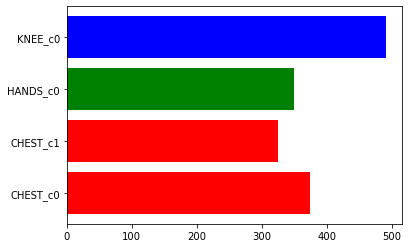

In [373]:
# DISPLAYING DISTRIBUTION
parts = np.unique(TARGET_TRAIN_CD4)
count=[]
for part in parts:
    count.append(TARGET_TRAIN_CD4.count(part))
plt.barh(parts,count,color="rrgb")
plt.show()

In [374]:
# RENAMING TARGET LABELS THAT SO I CAN TRACK AND REMAIN AFTER LEARNING
def re_label_cd(targets):
    TAR=[]
    for part in targets:
        if part == 'CHEST_c0':
            TAR.append(0)
        elif part == 'HANDS_c0':
            TAR.append(1)
        elif part == 'KNEE_c0':
            TAR.append(2)
        elif part == 'CHEST_c1':
            TAR.append(3)
    return (TAR)

In [375]:
# reshaping data for Neural Network
X_train_reshape4 = np.array(HOG_train3,dtype='float64').reshape(len(HOG_train3),len(HOG_train3[0]),1,1) # reshaping list of features to 4D for CNN
X_test_reshape4 = np.array(HOG_test3,dtype='float64').reshape(len(HOG_test3), len(HOG_test3[0]),1,1) # NOTE TEST REMAINS THE SAME

# changing labels to array like categorical labels vital for CNN training
Y_train_categorical4 = np_utils.to_categorical(re_label_cd(TARGET_TRAIN_CD4), 4) # 4 equal to the number of classes from decomposition
Y_test_categorical4 = np_utils.to_categorical(re_label(TARGET_test3), 3)  # NOTE TEST REMAINS THE SAME
# function 're_label' defined earlier to change 'CHEST'==0, 'HANDS'==1 and 'KNEE'==2 

In [376]:
TARGET_TRAIN_CD4[9:12]

['KNEE_c0', 'KNEE_c0', 'KNEE_c0']

In [377]:
Y_train_categorical4[9:12]

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [378]:
# Function to recombine the Two classes CHEST_c1 and CHEST_c0
def re_compose (predictions):
    new_pred = []
    for pred in list(predictions):
        if str(pred) == '[0, 0, 0, 1]': # for CHEST_c1
            new_pred.append([1., 0., 0.]) # CHEST
        else:
            new_pred.append(pred[0:3]) # reshaping prediction array length from 4 to 3
    return(np.array(new_pred, dtype='float32'))

#### training model

In [379]:
# Define model architecture same as with model1 above

model4 = Sequential()

model4.add(Input((len(HOG_train3[0]),1,1))) # expected input shape
model4.add(Conv2D(32, (3, 1), activation='relu'))
model4.add(ZeroPadding2D((2, 2))) # pads the border of input image with zeroes
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.25))# to reduce overfitting
model4.add(Flatten())  # flatten to come before dense output layer
model4.add(Dense(81, activation='relu'))   # the pre output dense layer greatly increases accuarcy density= square(no.categories)
model4.add(Dropout(0.25))# to reduce overfitting
model4.add(Dense(4, activation='softmax'))  # output layer to have 4 for the 4 categories

model4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 


In [380]:
model4.fit(X_train_reshape4,np.array(Y_train_categorical4),batch_size=20, epochs=1,verbose=1) # small batch better speed

78/78 [==============================] - 13s 160ms/step - loss: 0.3501 - accuracy: 0.8637


In [381]:
# the prediction are stored as floats in array. code below round up it to integers in a list
pred = model4.predict(X_test_reshape4)
pred_test=[]
for x in pred:
    pred_test.append([round(i) for i in list(x)])
pred_test4 = re_compose(pred_test)  # calling recompose function to reduce chest classes from 2 back to 1

In [382]:
print(classification_report(Y_test_categorical4, pred_test4, target_names=['CHEST','HANDS','KNEE']))

              precision    recall  f1-score   support

       CHEST       1.00      0.98      0.99       300
       HANDS       0.99      1.00      0.99       150
        KNEE       1.00      0.98      0.99       211

   micro avg       1.00      0.98      0.99       661
   macro avg       1.00      0.99      0.99       661
weighted avg       1.00      0.98      0.99       661
 samples avg       0.98      0.98      0.98       661



C:\Users\program_AD\anaconda3\envs\pro_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* with the class decomposition we observe that the model performs almost equally with all classes as expected

In [383]:
x=  classification_report(Y_test_categorical4, pred_test4, target_names=['CHEST','HANDS','KNEE'])
model4f1 = [ r.split(" "*6)[4] for r in x.split("\n\n")[1].split("\n") ]
f1scores.loc["experiment4"]= model4f1

C:\Users\program_AD\anaconda3\envs\pro_env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### TABLES AND SUMMARY

In [384]:
# TABLE OF F1 SCOCE ON ALL MODELS
f1scores

,CHEST,HANDS,KNEE
experiment1,0.46,0.27,0.33
experiment2,0.99,0.98,0.98
experiment3,0.99,1.00,0.99
experiment4,0.99,0.99,0.99


#### discussion
F1-Score was selected rather than accuracy for this summary because accuracy is not the best for imbalance classification
* In the first experiment the chest images had the best f1 score
* After applying oversampling and image agumentation performance improved
* By preprocessing and extracting the features the CNN performed better as seen in experiment 3
* After applying class decompositing technique to the extracted we observe an equally high performance and similar levels amongst the classes.


**Google drive** [link to My Repo](https://drive.google.com/drive/folders/11KdoHWtTMoV-oAqYfaUxnErCzmaasvxa?usp=sharing)

**REFERENCES:**

1. Carlos Francisco Moreno-Garc´ıa, Chrisina Jayne, Eyad Elyan 2021 Class-Decomposition and Augmentation for Imbalanced Data Sentiment Analysis pp.1-2

2. Emily Potyraj,2021, 4 Ways to Improve Class Imbalance for Image Data,available from: https://towardsdatascience.com/4-ways-to-improve-class-imbalance-for-image-data-9adec8f390f1

3. François Chollet,2017 *Deep Learning with Python.* Manning

4. Rokas Balsys,2021,TensorFlow Keras CNN Tutorial,available from:
https://python.plainenglish.io/tensorflow-keras-cnn-tutorial-bceceaeb5efa [accessed 4 mar 2022]
